# Homework 7
#### Cody Costa, David Loi

### Problem 1:

#### Import necessary module(s)

In [46]:
import numpy as np

### Function to generate random symmetric matrix:

In [47]:
''' function to generate 2x2 symmetric matrix whose
    elements are constrained to be between 0 and 10 '''

size: int = 2
max_value: int = 10

def generate_symmetric_matrix(size) -> np.ndarray:

    matrix: np.ndarray = np.zeros([size, size])

    for element in range(size):

        # diagonal matrix
        matrix[element, element] = np.random.randint(0, max_value)

        # fill it such that matrix is symmetric
        filler = np.array([np.random.randint(0, max_value) for e in range(size - element - 1)])

        matrix[element, element + 1:] = filler
        matrix[element + 1:, element] = filler

    return matrix

    # verify the matrix has a nonzero determinant

    # if np.linalg.det(matrix):
    #     return matrix
    
    # else:
    #     generate_symmetric_matrix(size)


#### test that function works:

In [48]:
M: np.ndarray = generate_symmetric_matrix(2)
print(M)

[[3. 2.]
 [2. 2.]]


### Decomposition

use the property that a matrix A can be equated to A = PDP^T where...

#### D = diagonal matrix of eigenvalues
#### P = matrix of eigenvectors

In [49]:
eigenvalues, eigenvectors = np.linalg.eig(M)
print(eigenvalues, '\n')
print(eigenvectors)

[4.56155281 0.43844719] 

[[ 0.78820544 -0.61541221]
 [ 0.61541221  0.78820544]]


### Find SVD of matrix

In [50]:
U, S, U_T = (np.linalg.svd(M))
print(U, '\n\n', S, '\n\n', U_T)


[[-0.78820544 -0.61541221]
 [-0.61541221  0.78820544]] 

 [4.56155281 0.43844719] 

 [[-0.78820544 -0.61541221]
 [-0.61541221  0.78820544]]


### Define our P and D matrices

In [51]:
# P: np.ndarray = 1 / abs(np.min(eigenvectors)) * eigenvectors
# P

P = eigenvectors
print(P)

[[ 0.78820544 -0.61541221]
 [ 0.61541221  0.78820544]]


### Craft the diagonal matrix of eigenvalues D

In [52]:
D: np.ndarray = np.zeros([size, size])
for idx, val in enumerate(S):
    D[idx, idx] = eigenvalues[idx]

print(D)

[[4.56155281 0.        ]
 [0.         0.43844719]]


In [53]:
''' test our P and D matrices are accurate via A = P D P^T '''

print(P @ D @ P.T, '\n')
print(M)


[[3. 2.]
 [2. 2.]] 

[[3. 2.]
 [2. 2.]]


### More decomposition relations

let's normalize the matrix P (eigenvectors) and establish the relation m @ V == V @ D

In [54]:
P

array([[ 0.78820544, -0.61541221],
       [ 0.61541221,  0.78820544]])

In [55]:
''' normalize eigenvectors '''

V = np.zeros([size, size])

V[:, 0] = P[:, 0] / np.max(abs(P[:, 0]))
V[:, 1] = P[:, 1] / np.max(abs(P[:, 1]))

In [56]:
V

array([[ 1.        , -0.78077641],
       [ 0.78077641,  1.        ]])

In [57]:
''' check for correctness'''

res1 = np.round(M @ V, 2)
res2 = np.round(V @ D, 2)
print(res1, '\n\n', res2)

[[ 4.56 -0.34]
 [ 3.56  0.44]] 

 [[ 4.56 -0.34]
 [ 3.56  0.44]]


#### Given this relation, we can conclude the matrix V are the eigenvectors of m

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


### Problem 2:

### Necessary Imports

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.decomposition import PCA

### Define Global Vars

In [59]:
IMAGE_ROWS: int = 28
IMAGE_SET_SIZE: int = 6

GAUSSIAN_NOISE: int = 10
PCA_COUNT: int = 4

### Load Data to Compress

In [60]:
emnist_digits = pd.read_csv('emnist-digits-test.csv', header=None, sep=',', dtype='uint')
print(emnist_digits.shape)
emnist_digits.head()

(40000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Useful Accessory Functions

In [61]:
def extract_image_vector(index, dataset=emnist_digits):
    'Return a square matrix from a row in the Pandas DataFrame.'
    return emnist_digits.values[index,1:]

def add_gaussian_noise(the_vector, std_dev=GAUSSIAN_NOISE):
    'Add zero mean' 
    noise = np.random.normal(0,std_dev, len(the_vector) )
    return the_vector + noise

def mean_square_error(modified_vector, original_image_vector):
    'A distance measure between two image matrices'
    n = sum(original_image_vector.shape)
    # print('n', n)
    if n != sum(modified_vector.shape):
        print(f'Vector lengths do not match: {n}')
        return None
    # Compute mean sum of squares
    rmse = math.sqrt(np.square(modified_vector - original_image_vector).sum())/n
    return rmse

# Test - comparing a vector with iteself should equal 0
mean_square_error(emnist_digits.values[9,1:], emnist_digits.values[9,1:])

0.0

### Example Function To View An Image

In [62]:
def view_one_image(index, dataset=emnist_digits):
    '''Take one row of the data that contains one image, 
    reshape it to a square for display, and return the class'''
    the_class = emnist_digits.values[index, 0]
    
    the_vector = extract_image_vector(index, dataset)
    
    # test adding some noise to the image
    # the_vector = add_gaussian_noise(extract_image_vector(index, dataset), std_dev=2*GAUSSIAN_NOISE_STD_DEV)

    image = plt.imshow(the_vector.reshape(IMAGE_ROWS, IMAGE_ROWS).T, cmap='GnBu')
    plt.show(image)
    return the_class

# view_one_image(4)

### Digit To Compress And Reconstruct (CAN CHANGE THIS)

In [63]:
DIGIT = 5

### Gather Images To Compress With Some Added Noise

In [64]:
training_images = np.zeros([IMAGE_SET_SIZE, IMAGE_ROWS**2])

row = 0

for j in range(emnist_digits.shape[0]):
    current_digit = emnist_digits.values[j, 0]
    if current_digit == DIGIT:
        training_images[row, :] = add_gaussian_noise(extract_image_vector(j), GAUSSIAN_NOISE * 3)

        row += 1

        if row >= IMAGE_SET_SIZE:
            break


print(f'Training shape {training_images.shape}')

Training shape (6, 784)


### Test Showing A Raw Image With Noise

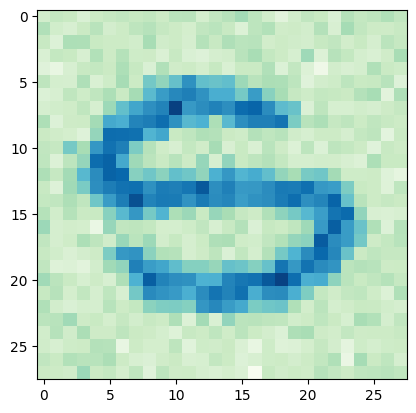

In [65]:
# test showing a raw image with intriduced noise
img = plt.imshow(training_images[0, :].reshape([IMAGE_ROWS, IMAGE_ROWS]).T, cmap='GnBu')

### Function To Plot Error VS Num of PCA Components

In [66]:
def vary_components(image_vector, noise_level):
    the_vector = add_gaussian_noise(image_vector, noise_level)
    train_image = the_vector.reshape(IMAGE_ROWS,IMAGE_ROWS)
    errors = np.zeros(IMAGE_ROWS)
    
    for component_count in range(2, IMAGE_ROWS):
        v_pca_model = PCA(n_components=component_count)
        v_pca_model.fit(train_image)
        image_space = v_pca_model.transform(train_image)
        image_reconstruction = v_pca_model.inverse_transform(image_space)
        base_error = mean_square_error(the_vector, image_vector)
        errors[component_count] =  mean_square_error(image_reconstruction.reshape(784), image_vector.reshape(784))

    return errors

### Transform Each Image In The Set And Compress

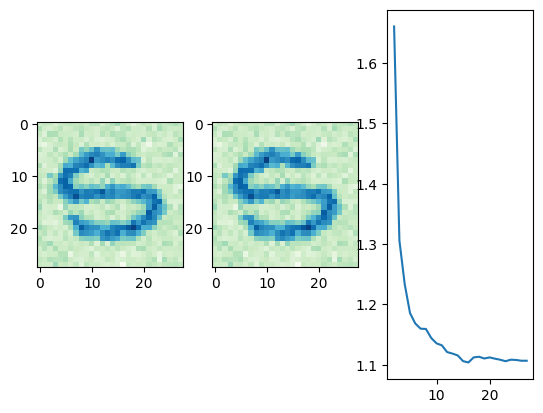

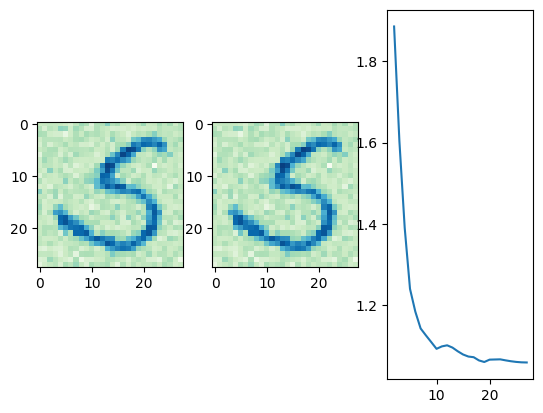

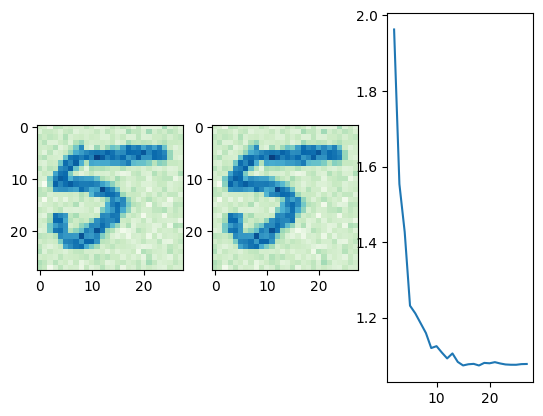

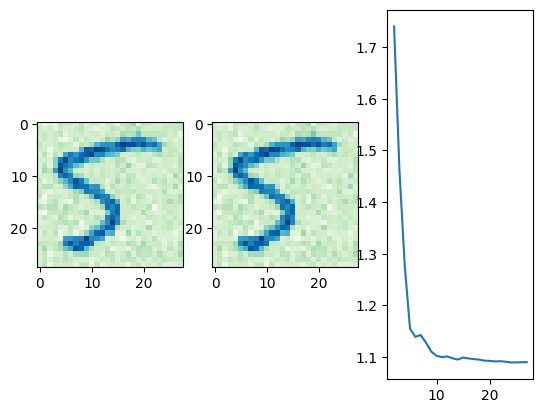

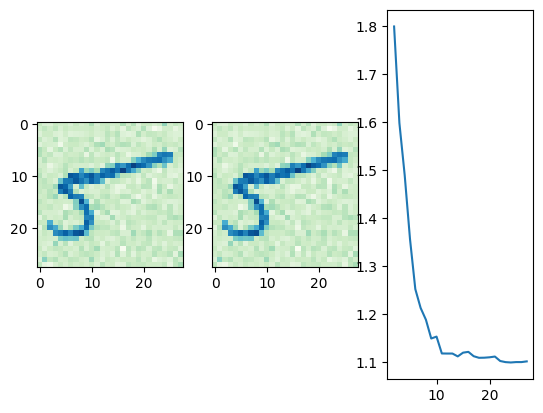

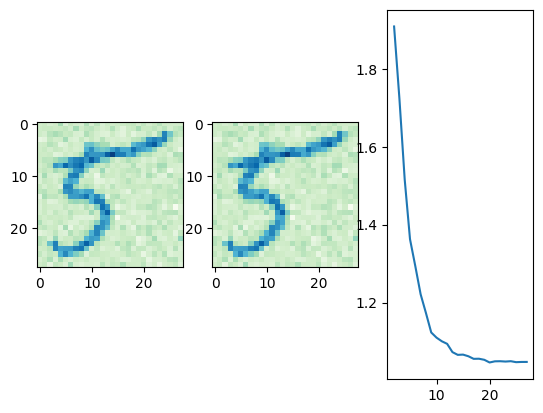

In [91]:
for row in range(IMAGE_SET_SIZE):

    ''' transform each training image '''

    img = training_images[row, :].reshape([IMAGE_ROWS, IMAGE_ROWS]).T
    img_pca_model = PCA(n_components=IMAGE_ROWS)
    img_pca_model.fit(img)

    img_space = img_pca_model.transform(img)
    # print(img_space.shape)


    ''' inverse transform trainign images '''

    img_reconstruct = img_pca_model.inverse_transform(img_space)
    # print(img_reconstruct.shape)


    ''' subplots for each image and reconstruction '''

    # plt.subplot(1, 3, 1)

    # plt.imshow(img, cmap='GnBu')

    # plt.subplot(1, 3, 2)

    # plt.imshow(img_reconstruct, cmap='GnBu')

    # plt.subplot(1, 3, 3)

    # plt.plot(range(IMAGE_ROWS), vary_components(training_images[row, :], GAUSSIAN_NOISE * 3))

    fit, axes = plt.subplots(1, 3)
    
    axes[0].imshow(img, cmap='GnBu')
    axes[1].imshow(img_reconstruct, cmap='GnBu')
    axes[2].plot(range(2, IMAGE_ROWS), vary_components(training_images[row, :], GAUSSIAN_NOISE * 3)[2:])
    
    # print(mean_square_error(img_reconstruct.reshape(IMAGE_ROWS**2), img.reshape(IMAGE_ROWS**2)))